# VideoDB Search Tutorial

In this tutorial, we will explore search, search result tuning, and search result evaluation using VideoDB.

To keep it super simple, we have a countdown video of 30 seconds. We'll index each second scene of the video and experiment with the search.

## Steps:
1. **Indexing the Video:**
- Split the 30-second countdown video into 30 individual scenes, each representing one second.
- Index each scene with its corresponding timestamp and description.


3. **Performing Searches:**
- Conduct keyword searches for simple queries like "six" and "teen."
- Conduct semantic searches for natural language queries like "find me a 6."


4. **Search Result Tuning:**
- Adjust parameters to improve the relevance of search results.
- Compare the performance of keyword and semantic searches for various queries.


5. **Search Result Evaluation:**
- Define ground truth for each query, such as the expected timestamps for "six."
- Evaluate search results against the ground truth to measure effectiveness.
- Apply additional layers of intelligence, such as using an LLM, to handle complex queries like "Find me all the numbers greater than six."

By following these steps, you will gain a deeper understanding of how to fine-tune and evaluate search results within VideoDB.


### 🧰 Setup

In [ ]:
pip install videodb

  Preparing metadata (setup.py) ... done
  Created wheel for videodb: filename=videodb-0.2.2-py3-none-any.whl size=26387 sha256=4f2536ac7b2dbbdf9ee09713119581f4e2beee0c177d069beb4d2b965e46b6ed
  Stored in directory: /root/.cache/pip/wheels/50/f2/45/5ffdf903ea6dbd80e90c4d2c5464aa693f3895151e259475b7
Successfully built videodb


### 🔑 API Keys

In [ ]:
import videodb
import os
from getpass import getpass

api_key = getpass("Please enter your VideoDB API Key: ")

os.environ["VIDEO_DB_API_KEY"] = api_key

### 🌐 Connect to VideoDB

In [2]:
from videodb import connect
from videodb import SceneExtractionType, SearchType, IndexType

conn = connect()
coll = conn.get_collection()

### 🎥 Load Sample Video

In [17]:
video = coll.upload(url="https://www.youtube.com/watch?v=tWoo8i_VkvI")
video_id = video.id
print(video)
video.play()

Video(id=m-536be1b2-b67a-4cb5-a1c9-49e5d08340b4, collection_id=c-b0d8f234-10c8-40f4-bd2c-276b1613f631, stream_url=https://stream.videodb.io/v3/published/manifests/b3a9fdc0-c344-48de-9d35-b16f661b824b.m3u8, player_url=https://console.videodb.io/player?url=https://stream.videodb.io/v3/published/manifests/b3a9fdc0-c344-48de-9d35-b16f661b824b.m3u8, name=30 SECOND TIMER, description=None, thumbnail_url=None, length=30.000181)


'https://console.videodb.io/player?url=https://stream.videodb.io/v3/published/manifests/b3a9fdc0-c344-48de-9d35-b16f661b824b.m3u8'

### 📸 Scene Index

Use scene index to index the video for each second to get the visual information of displayed seconds e.g: thirty seconds, twenty-nine seconds etc.

In [18]:
# Get the per_second_index_id if already available otherwise index it in else
available_scene_indexes = video.list_scene_index()
for scene_index in available_scene_indexes:
    if scene_index["name"] == "per_second":
        per_second_index_id = scene_index["scene_index_id"]
        break
else:
    # If index not found
    per_second_index_id = video.index_scenes(
        extraction_type=SceneExtractionType.time_based,
        extraction_config={"time": 1},
        prompt="Just write down the seconds in the given image in english like 'x seconds' without quotes where x is the seconds in image e.g: one second, two seconds and so on.",
        name="per_second"
)
video.get_scene_index(per_second_index_id)

### 📰 Print All Indexed Documents

In [19]:
print("(start, end) -> scene description")
print("-"*35)
per_second_scenes = video.get_scene_index(per_second_index_id)
for scene in per_second_scenes:
    print(f'({scene["start"]}, {scene["end"]}) -> {scene["description"]}')

(start, end) -> scene description
-----------------------------------
(0.0, 1.0) -> thirty seconds
(1.0, 2.0) -> twenty-nine seconds
(2.0, 3.0) -> twenty-eight seconds
(3.0, 4.0) -> twenty-seven seconds
(4.0, 5.0) -> twenty-six seconds
(5.0, 6.0) -> twenty-five seconds
(6.0, 7.0) -> Twenty-four seconds
(7.0, 8.0) -> twenty-three seconds
(8.0, 9.0) -> Twenty-two seconds.
(9.0, 10.0) -> Twenty-one seconds
(10.0, 11.0) -> twenty seconds
(11.0, 12.0) -> nineteen seconds
(12.0, 13.0) -> eighteen seconds
(13.0, 14.0) -> Seventeen seconds
(14.0, 15.0) -> Sixteen seconds
(15.0, 16.0) -> fifteen seconds
(16.0, 17.0) -> fourteen seconds
(17.0, 18.0) -> Thirteen seconds
(18.0, 19.0) -> twelve seconds
(19.0, 20.0) -> eleven seconds
(20.0, 21.0) -> ten seconds
(21.0, 22.0) -> nine seconds
(22.0, 23.0) -> eight seconds
(23.0, 24.0) -> Seven seconds
(24.0, 25.0) -> six seconds
(25.0, 26.0) -> five seconds
(26.0, 27.0) -> four seconds
(27.0, 28.0) -> Three seconds
(28.0, 29.0) -> Two seconds
(29.0, 30

### 🧪 Search Evaluation Functions

Here we define function for evalaution with metrics of precision and recall. The above 30 scenes are all the indexed documents of video, each has a timestamp and a textual information of what is visually present in the scene. To understand precision and recall we need to undestand types of documents:

Each search will return some docs as the result those are **retrieved docs**.

  * From those retrieved docs some docs can be from our ground truth those are **retrieved relevant docs**.

  * And rest from those retrieved docs are **retrieved not relevant docs**.



The docs which are indexed but not in the search results are **not retrieved docs**.

  * Again from those non-retrieved docs some can be from our ground truth those are **not retrieved relevant docs**.

  * And rest of those non retrieved docs will be **not retrieved not relevant docs**.
```
🔪 Precision = No. of Relevant Docs Retrieved / No. of Retrieved Docs
🧠 Recall = No. of Relevant Docs Retrieved / No. of Relevant Docs
```



In [20]:
def calculate_overlap(true_start, true_end, prediction_start, prediction_end):
    overlap_start = max(true_start, prediction_start)
    overlap_end = min(true_end, prediction_end)
    return max(0, overlap_end - overlap_start)

def simple_evaluation(ground_truth, predictions):
    total_retrieved = len(predictions)
    total_relevant = len(ground_truth)
    total_relevant_retrived = 0

    for ground_truth_start, ground_truth_end in ground_truth:
        ground_truth_interval_duration = ground_truth_end - ground_truth_start
        processed = False
        for prediction_start, prediction_end in predictions:
            overlap = calculate_overlap(ground_truth_start, ground_truth_end, prediction_start, prediction_end)
            if overlap > 0:
                if not processed:
                    total_relevant_retrived += 1
                    processed = True
    precision = total_relevant_retrived / total_retrieved if total_retrieved else 0
    recall = total_relevant_retrived / total_relevant if total_relevant_retrived else 0

    return {
        "precision": precision,
        "recall": recall,
    }

def print_results_and_evaluation(result, ground_truth):
    shots = sorted(result.get_shots(), key=lambda k: k.search_score, reverse=True)
    for i, shot in enumerate(shots):
        print(f"Timestamp: ({shot.start}, {shot.end}), Text: {shot.text}, Score: {shot.search_score}")
    result_timestamps = [(shot.start, shot.end) for shot in shots]
    if ground_truth:
        eval = simple_evaluation(ground_truth, result_timestamps)
        print(f"Precision: {eval['precision']} Recall: {eval['recall']}")
        print("-"*30)

### ✅ Ground Truth


**Ground truth** is the ideal expected result.

In [21]:
queries = ["teen", "six"]

ground_truths = [
    [(11.0, 12.0), (12.0, 13.0) ,(13.0, 14.0), (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (17.0, 18.0)], # timestamp where teen is present
    [(4.0, 5.0), (14.0, 15.0), (24.0, 25.0)] # timestamp where six is present
]

grount_truth_values = [
    ["nineteen seconds", "eighteen seconds", "seventeen seconds", "sixteen seconds", "fifteen seconds", "fourteen seconds", "thirteen seconds"],
    ["twenty-six seconds", "sixteen seconds", "six seconds"]
]

Here our expectation for search query "teen" is to find all the timestamps where "teen" is in the description and same for the query "six".

So we have manually collected the timestamps above where expected documents are there, they are our ground truth for evaluation.

### Types Of Search

**Semantic Search**

Semantic search takes a query and matches its vector with the indexed documents and returns the matching documents with their respective score.
It is different then conventional search which is rigid, in semantic search it understand the context.

**Keyword Search**

VideoDB allows a keyword search on video level for all the indexes, it returns all the documents where the given query is present as the sub-string.

### Now we will experiment with different search configuration

### 🔍 Semantic Search

#### Default Configuration

In [22]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        query=query,
        stitch=False,
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 0.238964
Precision: 1.0 Recall: 0.14285714285714285
------------------------------
Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.615771949
Precision: 1.0 Recall: 0.3333333333333333
------------------------------


In VideoDB default configuration is set to give good quality result to users.
If you notice the precision is 1, but there might be a use case where loose filter is required we will experiment with the parameters to get the desired configurtion in next cells.

In VideoDB search can be tuned with `result_threshold`, `score_threshold` and `dynamic_score_percentage`

#### Score Threshold

`score_threshold` :

Applies an absolute threshold filter to the initially retrieved documents.

Retains documents with a relevance score greater than or equal to this value.

Default value of `score_threshold` is **0.2**

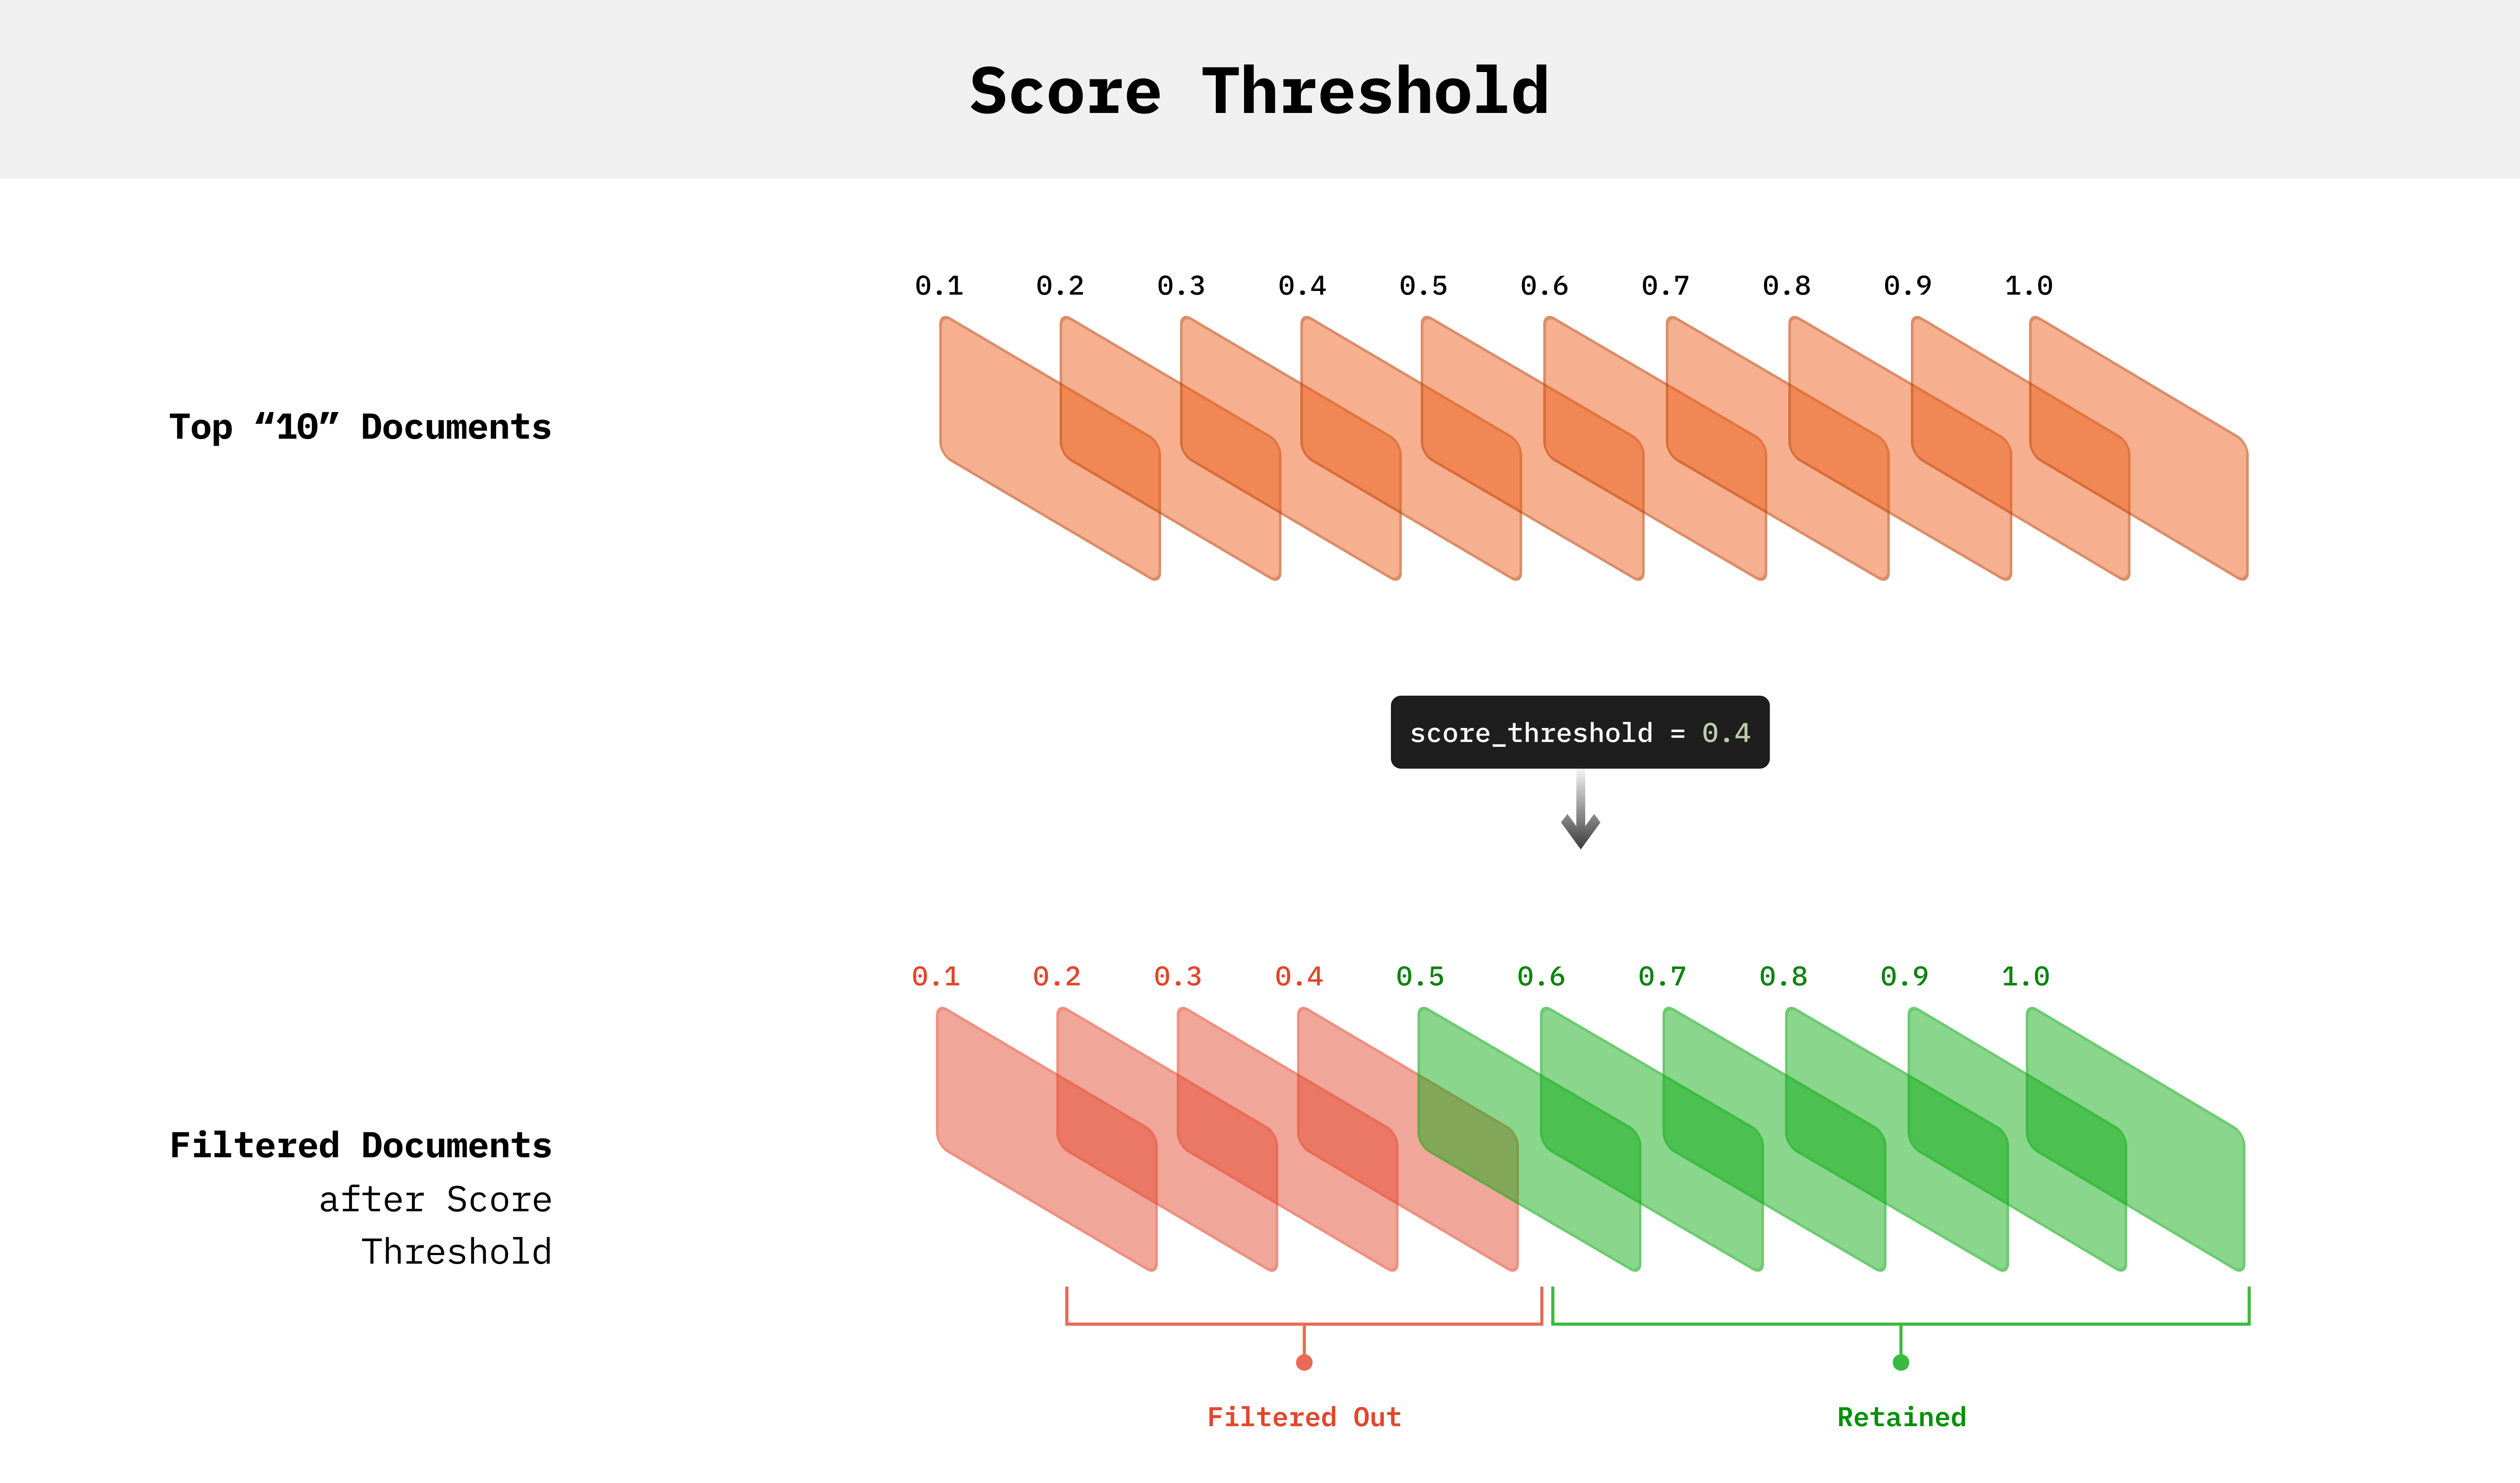

#### Score Threshold High

In [23]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        score_threshold=0.7,
        query=query,
        stitch=False,
    )
    print_results_and_evaluation(result, ground_truth)

Precision: 0 Recall: 0
------------------------------
Precision: 0 Recall: 0
------------------------------


If you check the previous default results our best scores were less then 0.7, that is why when we give `score_threshold` 0.7 we don't get any results.

#### Score Threshold Low

In [24]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        score_threshold=0.1,
        query=query,
        stitch=False,
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 0.238964
Precision: 1.0 Recall: 0.14285714285714285
------------------------------
Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.615771949
Precision: 1.0 Recall: 0.3333333333333333
------------------------------


Here we lowered the score_threshold to 0.1, but again got same result as default configuration where default score_threshold is 0.2.

There are two possibilites:

1 - It can be there are no matched document above 0.1


2 - Those documets above 0.1 are getting filtered by other configuration.

To find out what is the case we will move on to our next configuration `dynamic_score_percentage`

#### Dynamic Score Percentage

`dynamic_score_percentage`:
Implements an adaptive filtering mechanism to enhance result quality.

Useful when there is a significant gap between top results and tail results after score_threshold filter.

Selects only top x% of the score range (max-min), where x is the value of dynamic_score_percentage.

To calculate a dynamic threshold:

1. Identifies the minimum (min_score) and maximum (max_score) scores in the set.
2. Computes the score range: range = max_score - min_score
3. Calculates the dynamic threshold:
   `dynamic_threshold = max_score - (range * dynamic_score_percentage)`

Retains documents with scores greater than or equal to the dynamic threshold.

Default value is **20**.

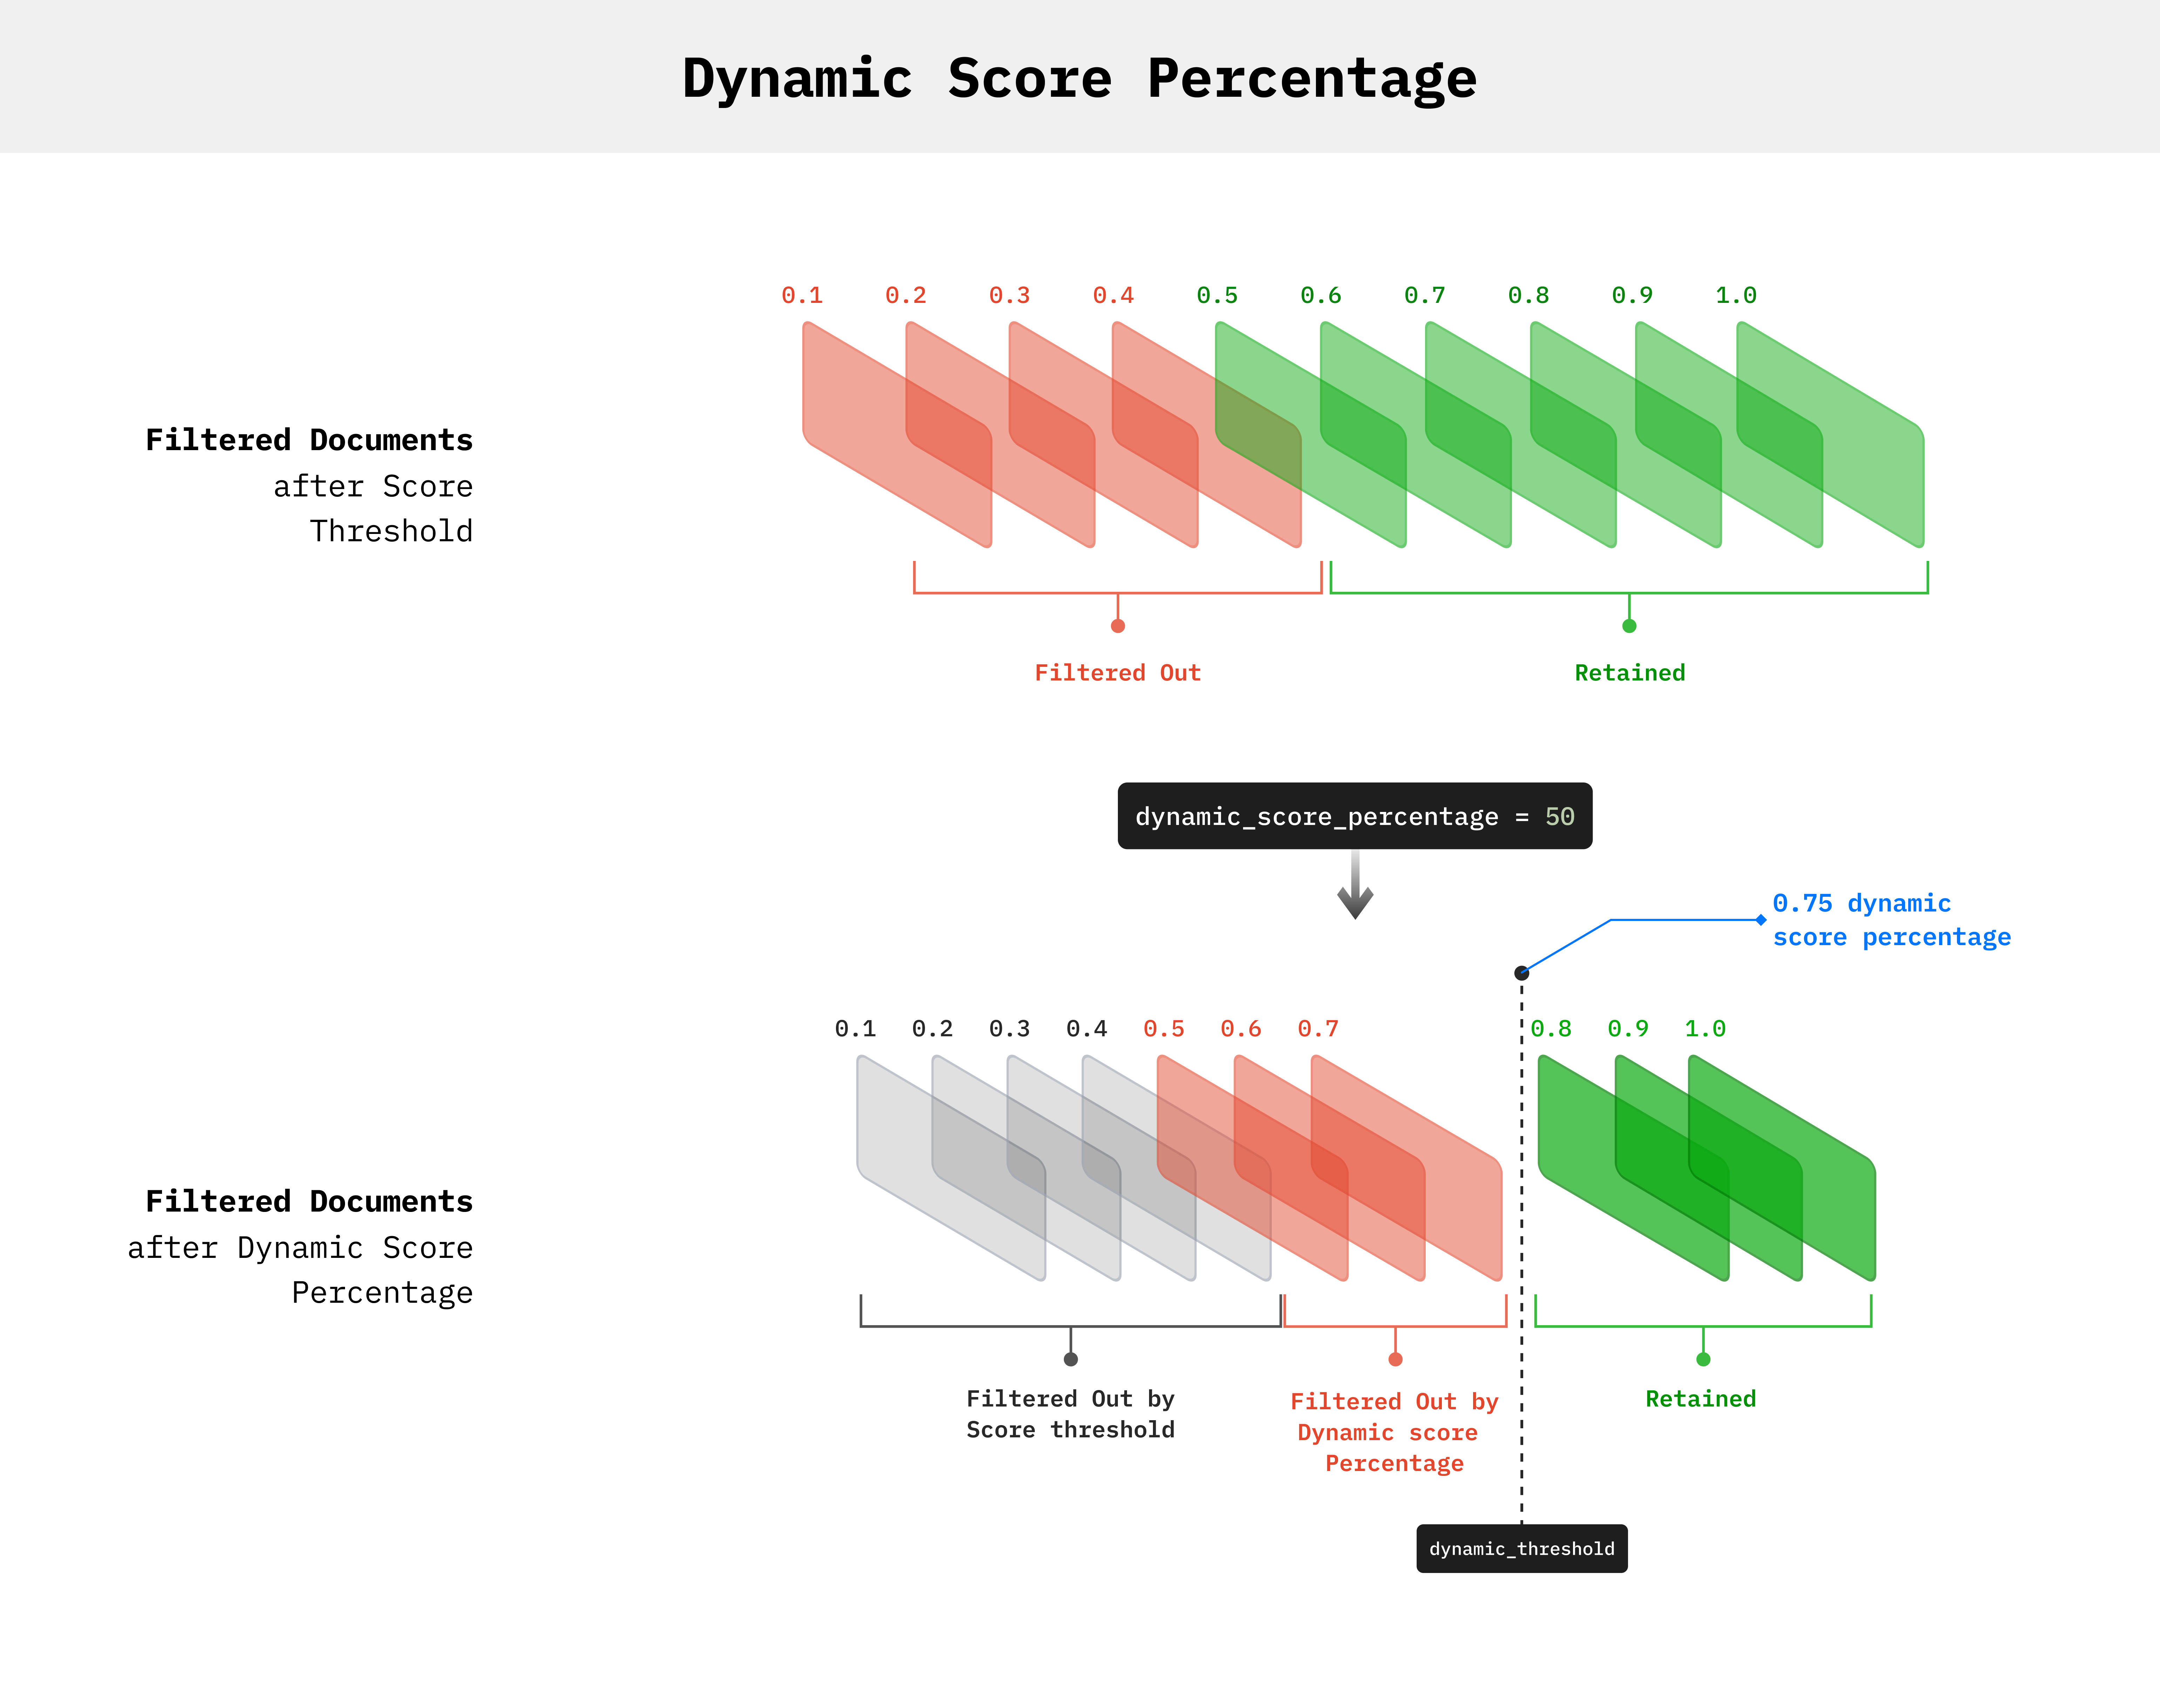

We can avoid filtering of results bt Dynamic Score Percentage value by keeping it max i.e 100%

In [25]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        score_threshold=0.1,
        dynamic_score_percentage=100,
        query=query,
        stitch=False
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 0.238964
Timestamp: (13.0, 14.0), Text: Seventeen seconds, Score: 0.22908248
Timestamp: (17.0, 18.0), Text: Thirteen seconds, Score: 0.223773167
Timestamp: (10.0, 11.0), Text: twenty seconds, Score: 0.206854507
Timestamp: (16.0, 17.0), Text: fourteen seconds, Score: 0.19996202
Precision: 0.8 Recall: 0.5714285714285714
------------------------------
Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.615771949
Timestamp: (23.0, 24.0), Text: Seven seconds, Score: 0.524921656
Timestamp: (22.0, 23.0), Text: eight seconds, Score: 0.483752072
Timestamp: (25.0, 26.0), Text: five seconds, Score: 0.46505782
Timestamp: (21.0, 22.0), Text: nine seconds, Score: 0.445872307
Precision: 0.2 Recall: 0.3333333333333333
------------------------------


So here we got more results so it was a case #2 mentioned above, there are docs > 0.1 but they were filtered by dynamic_score_percentage.

If you notice our recall has improved, but our accurracy has decreased, we will come to this point towards the end, stay tuned.

It returned 5 results, why 5? what if I need more? to tweak that let's move on to our next configuration `result_threshold`

#### Result Threshold

`result_threshold` :
Defines the initial filter for document retrieval from the index.

Selects the top N matching documents, where N is the value of result_threshold.

Default is **5**.

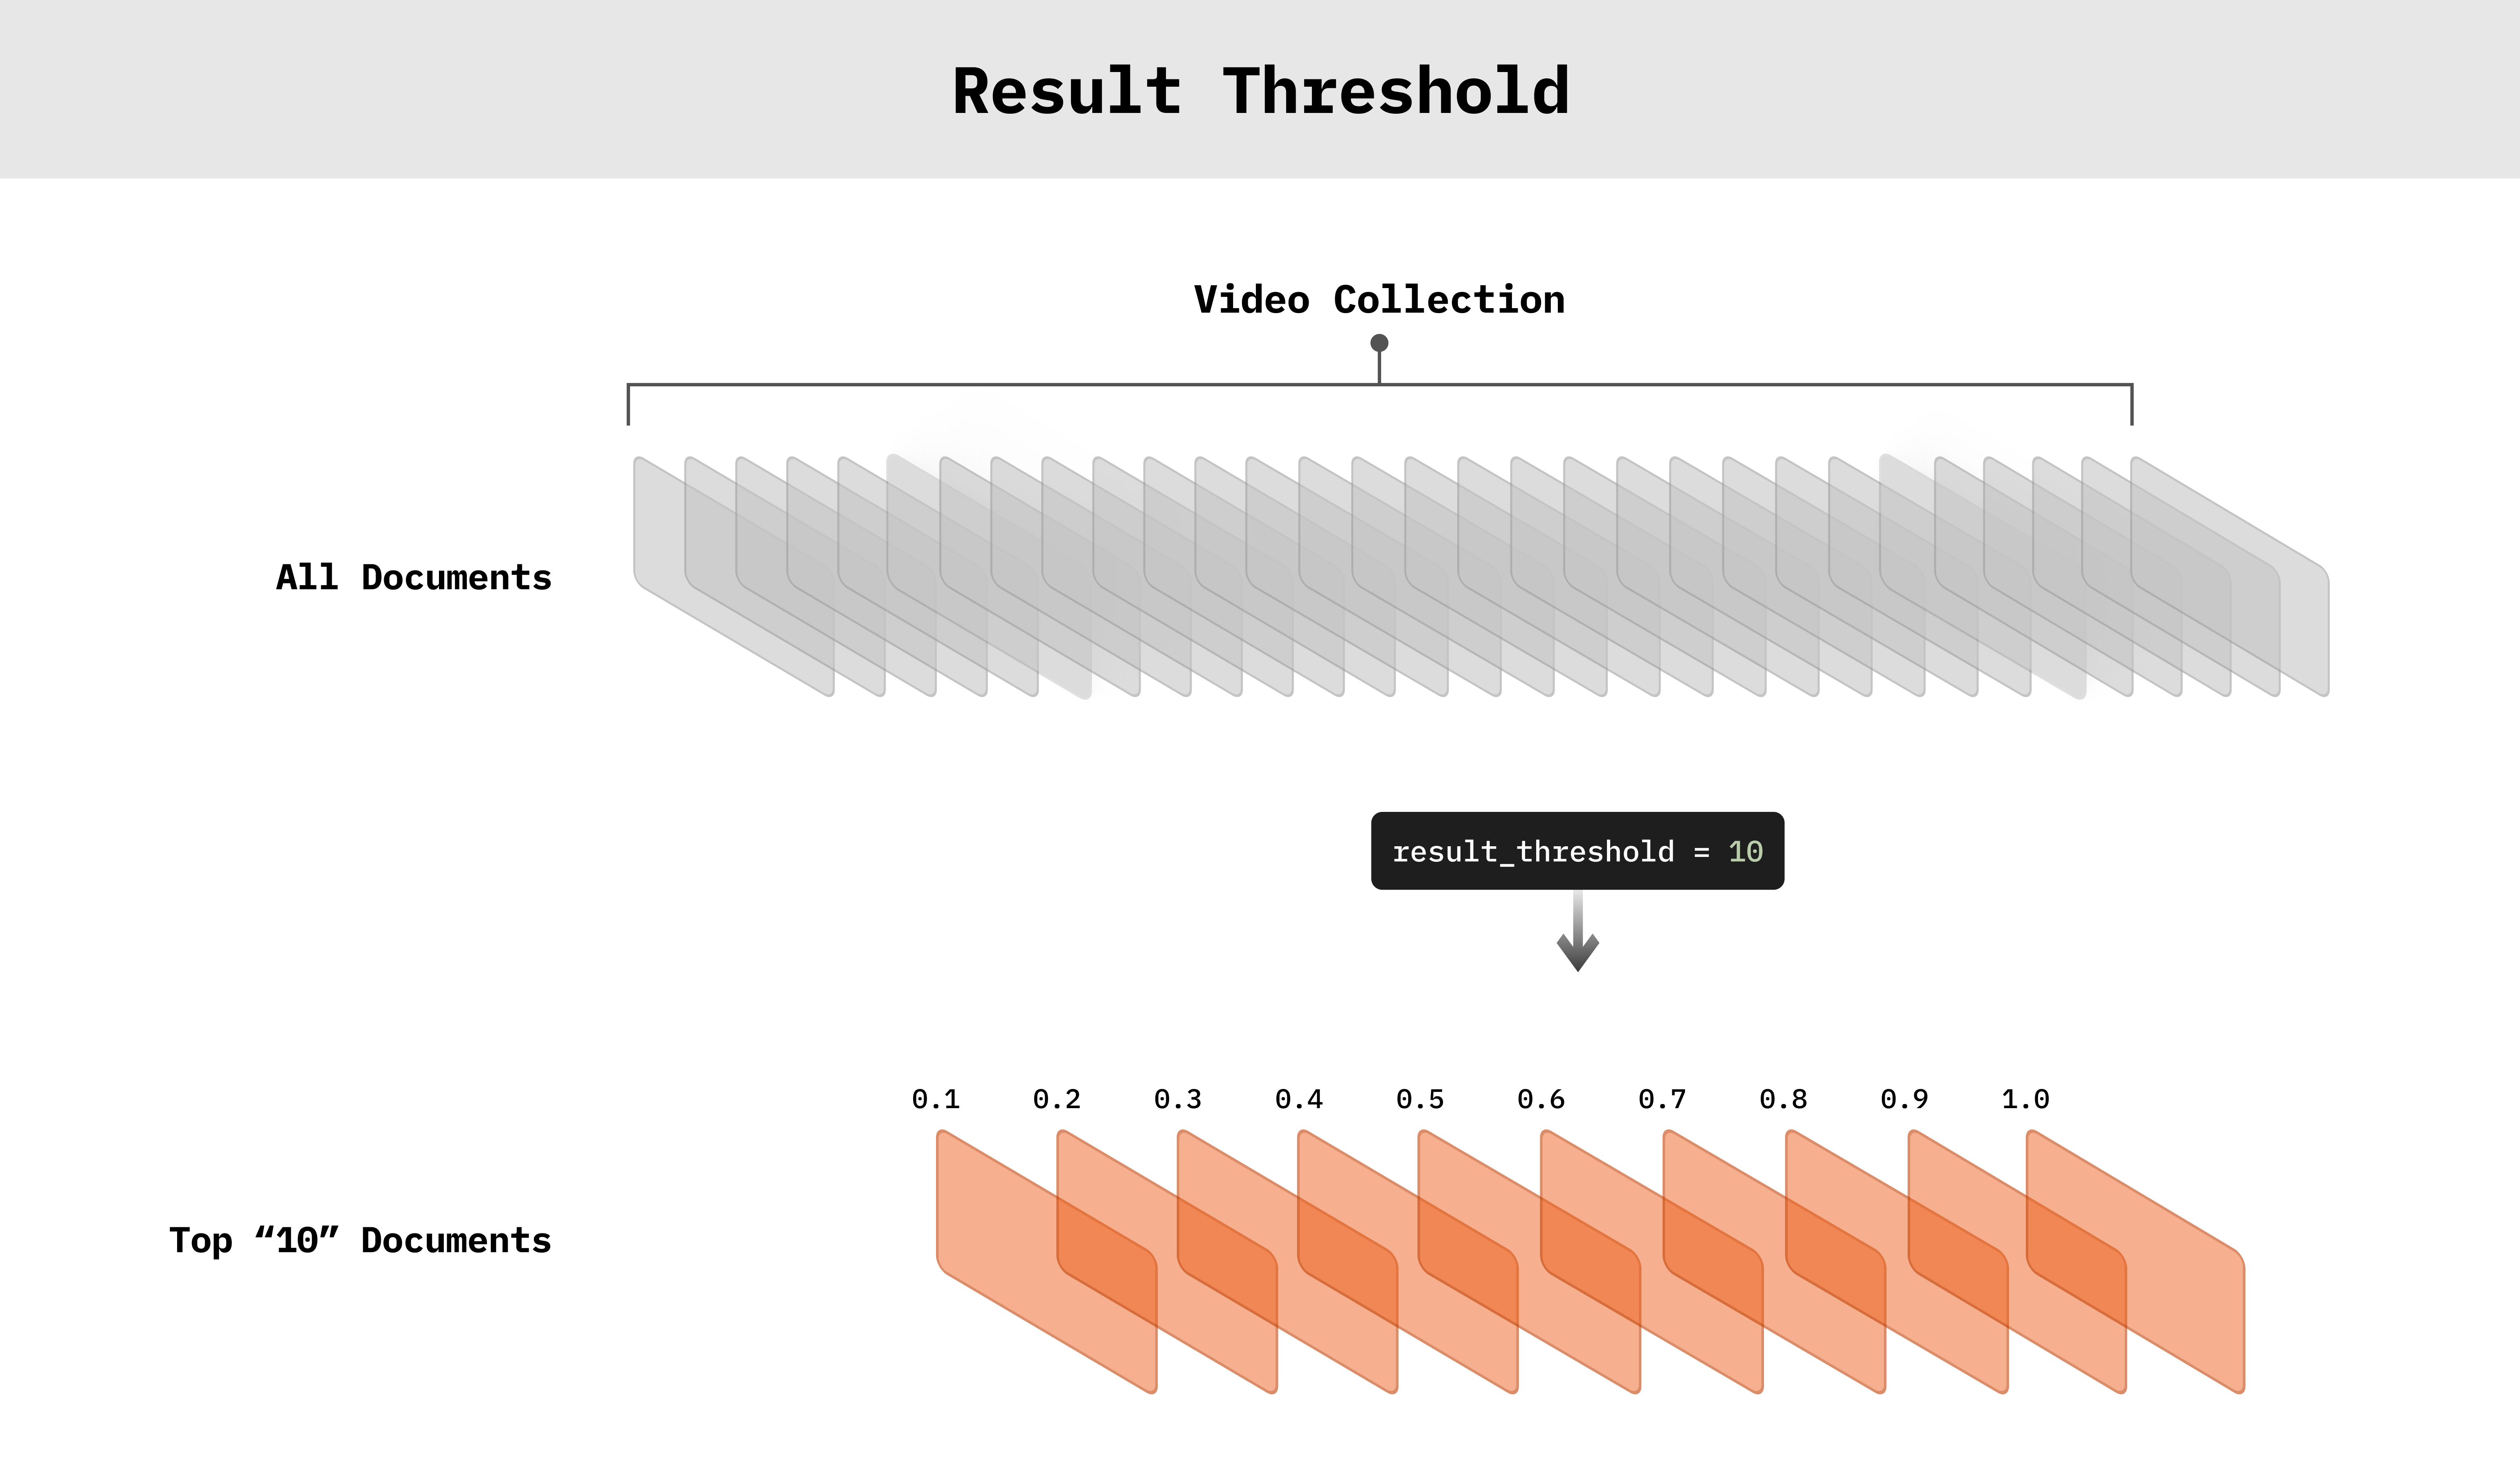

In [26]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        result_threshold=30,
        score_threshold=0.1,
        dynamic_score_percentage=100,
        query=query,
        stitch=False
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 0.238964
Timestamp: (13.0, 14.0), Text: Seventeen seconds, Score: 0.22908248
Timestamp: (17.0, 18.0), Text: Thirteen seconds, Score: 0.223773167
Timestamp: (10.0, 11.0), Text: twenty seconds, Score: 0.206854507
Timestamp: (16.0, 17.0), Text: fourteen seconds, Score: 0.19996202
Timestamp: (14.0, 15.0), Text: Sixteen seconds, Score: 0.194518849
Timestamp: (20.0, 21.0), Text: ten seconds, Score: 0.190675929
Timestamp: (11.0, 12.0), Text: nineteen seconds, Score: 0.187749654
Timestamp: (0.0, 1.0), Text: thirty seconds, Score: 0.173564062
Timestamp: (9.0, 10.0), Text: Twenty-one seconds, Score: 0.171356604
Timestamp: (18.0, 19.0), Text: twelve seconds, Score: 0.167239055
Timestamp: (5.0, 6.0), Text: twenty-five seconds, Score: 0.15832071
Timestamp: (3.0, 4.0), Text: twenty-seven seconds, Score: 0.151504144
Timestamp: (1.0, 2.0), Text: twenty-nine seconds, Score: 0.150839731
Timestamp: (12.0, 13.0), Text: eighteen seconds, Score: 0.14861

**Recall and Precision Tradeoff**

Recall measures the ability of a model to find all relevant cases within a dataset. The more documents you retrieve, the higher the recall. This metric improves as you increase the number of documents retrieved, as it either remains the same or grows, but it never decreases.

Precision, on the other hand, refers to the proportion of positive identifications that were actually correct. As you retrieve more documents, precision typically decreases because the likelihood of including false positives increases.

Tweaking to get good balance below:

In [13]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        result_threshold=30,
        score_threshold=0.15,
        dynamic_score_percentage=40,
        query=query,
        stitch=False
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 0.238964021
Timestamp: (13.0, 14.0), Text: Seventeen seconds, Score: 0.229082495
Timestamp: (17.0, 18.0), Text: thirteen seconds, Score: 0.223773167
Timestamp: (10.0, 11.0), Text: twenty seconds, Score: 0.206854492
Precision: 0.75 Recall: 0.42857142857142855
------------------------------
Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.61577177
Timestamp: (23.0, 24.0), Text: seven seconds, Score: 0.524921894
Timestamp: (22.0, 23.0), Text: eight seconds, Score: 0.483752072
Precision: 0.3333333333333333 Recall: 0.3333333333333333
------------------------------


### Keyword Search

In [14]:
for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.keyword,
        scene_index_id=per_second_index_id,
        query=query,
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (11.0, 12.0), Text: nineteen seconds, Score: 1
Timestamp: (12.0, 13.0), Text: eighteen seconds, Score: 1
Timestamp: (13.0, 14.0), Text: Seventeen seconds, Score: 1
Timestamp: (14.0, 15.0), Text: Sixteen seconds, Score: 1
Timestamp: (15.0, 16.0), Text: fifteen seconds, Score: 1
Timestamp: (16.0, 17.0), Text: fourteen seconds, Score: 1
Timestamp: (17.0, 18.0), Text: thirteen seconds, Score: 1
Precision: 1.0 Recall: 1.0
------------------------------
Timestamp: (4.0, 5.0), Text: twenty-six seconds, Score: 1
Timestamp: (14.0, 15.0), Text: Sixteen seconds, Score: 1
Timestamp: (24.0, 25.0), Text: six seconds, Score: 1
Precision: 1.0 Recall: 1.0
------------------------------


### Outcome

As you can see the keyword search is best suited in the case where queries like `"teen"` and `"six"` are expected.

But what if the queries are in natural language like "find me a 6" then semantic search is best suited.

In [15]:
queries = ["where is 6"]
ground_truths = [[(24.0, 25.0)]]

for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
            index_type=IndexType.scene,
            search_type=SearchType.semantic,
            scene_index_id=per_second_index_id,
            dynamic_score_threshold=30,
            query=query,
            stitch=False,
    )
    print_results_and_evaluation(result, ground_truth)

for query, ground_truth in zip(queries, ground_truths):
    result = video.search(
            index_type=IndexType.scene,
            search_type=SearchType.keyword,
            scene_index_id=per_second_index_id,
            query=query,
            stitch=False,
    )
    print_results_and_evaluation(result, ground_truth)

Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.407446325
Precision: 1.0 Recall: 1.0
------------------------------
Precision: 0 Recall: 0
------------------------------


### Bonus

For complex queries like `"Find me all the numbers greater than six"` will not work since search is just matching the query with document in vector space and returning the matching documents.

In above case by applying loose filter you can get all the matching docs with the query but you will have to plug in additional layer of intellegence with LLM and pass the matched documents for LLM to curate a response for desired query.


In [16]:
query = "Find me all numbers greater than six"

result = video.search(
        index_type=IndexType.scene,
        search_type=SearchType.semantic,
        scene_index_id=per_second_index_id,
        result_threshold=30,
        score_threshold=0.01,
        dynamic_score_percentage=100,
        query=query,
        stitch=False,
)
print_results_and_evaluation(result, None)

Timestamp: (24.0, 25.0), Text: six seconds, Score: 0.295759141
Timestamp: (23.0, 24.0), Text: seven seconds, Score: 0.200258017
Timestamp: (21.0, 22.0), Text: nine seconds, Score: 0.175311208
Timestamp: (22.0, 23.0), Text: eight seconds, Score: 0.167581424
Timestamp: (25.0, 26.0), Text: five seconds, Score: 0.160294697
Timestamp: (19.0, 20.0), Text: eleven seconds, Score: 0.157945186
Timestamp: (26.0, 27.0), Text: four seconds, Score: 0.15280211
Timestamp: (14.0, 15.0), Text: Sixteen seconds, Score: 0.144348249
Timestamp: (29.0, 30.0), Text: one second, Score: 0.138062477
Timestamp: (12.0, 13.0), Text: eighteen seconds, Score: 0.134970412
Timestamp: (4.0, 5.0), Text: twenty-six seconds, Score: 0.131241798
Timestamp: (17.0, 18.0), Text: thirteen seconds, Score: 0.129724517
Timestamp: (11.0, 12.0), Text: nineteen seconds, Score: 0.125424474
Timestamp: (18.0, 19.0), Text: twelve seconds, Score: 0.121010669
Timestamp: (20.0, 21.0), Text: ten seconds, Score: 0.116465807
Timestamp: (1.0, 2.0